In [24]:
using JuMP, Ipopt, Printf, Plots
using TestImages, Images, QuartzImageIO, ImageView

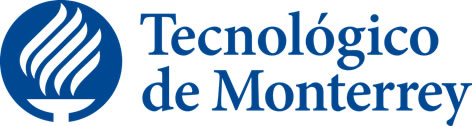

In [25]:
img = load("tec-logo.jpg")

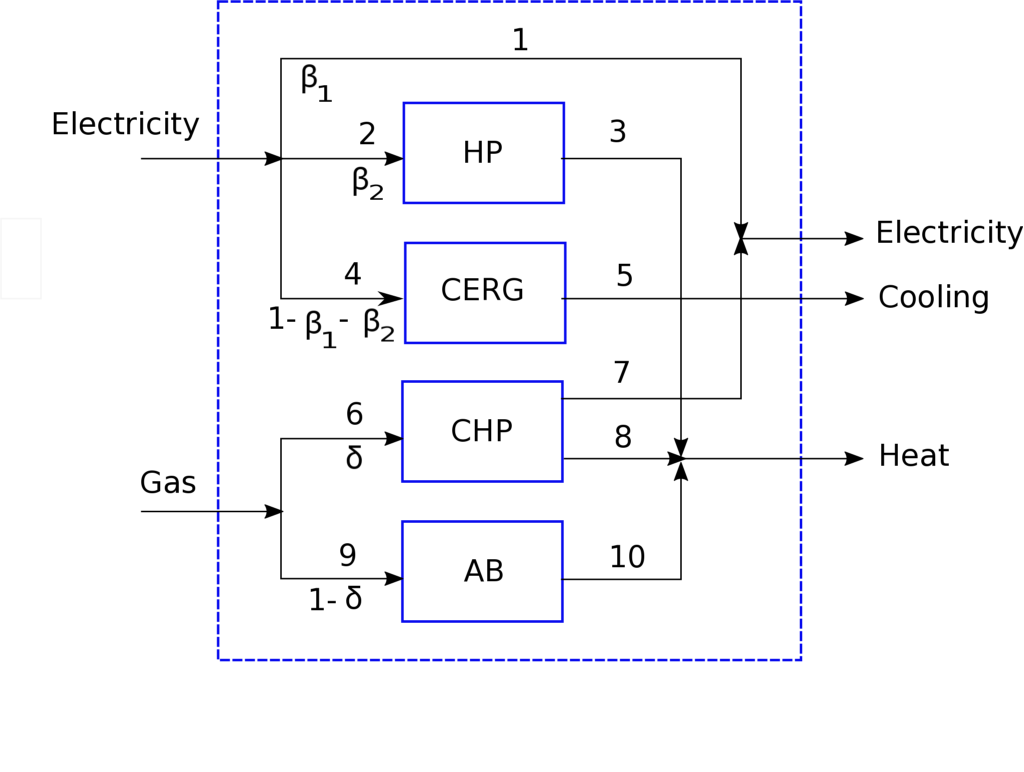

In [26]:
img = load("fig_eh_case5.png")

### Formulation of the optimization problem

#### (1)  Output Electricity ($P_e$) 
$$ P_e = \beta_1 \cdot L_e + v_7 $$
where,
\begin{eqnarray*}
v_7 &=& \eta_{CHP,e} \cdot v_6 \\
v_6 &=& \delta \cdot L_g \\
\end{eqnarray*}
so, 
\begin{eqnarray*}
v_7 &=& \eta_{CHP,e} \cdot \delta \cdot L_g \\
\end{eqnarray*}
hence,
$$ P_e = \beta_1 \cdot L_e +  \eta_{CHP,e} \cdot \delta \cdot L_g $$


#### (2)  Output Cooling  ($P_c$) 
$$ P_c = v_5 $$
where,
\begin{eqnarray*}
v_5 &=& \eta_{CERG} \cdot v_4 \\
v_4 &=& (1-\beta_1-\beta_2) \cdot L_e \\
\end{eqnarray*}
so,
$$ v_5 = \eta_{CERG}\cdot (1-\beta_1-\beta_2) \cdot L_e $$
hence,
$$ P_c = \eta_{CERG}\cdot (1-\beta_1-\beta_2) \cdot L_e $$

#### (3)  Output heat  ($P_h$) 
$$ P_h = v_{10} + v_8 + v_3 $$
where,
\begin{eqnarray*}
v_{10} &=& \eta_{AB,h} \cdot v_9 \\
v_9 &=& (1-\delta) \cdot L_g \\
\end{eqnarray*}
so,
$$ v_{10} = \eta_{AB,h} \cdot (1-\delta) \cdot L_g  $$
similarly,
\begin{eqnarray*}
v_{8} &=& \eta_{CHP,h} \cdot v_6 \\
v_6 &=& \delta \cdot L_g \\
\end{eqnarray*}
so,
$$ v_{8} = \eta_{CHP,h}\cdot \delta \cdot L_g $$
finally,
\begin{eqnarray*}
v_{3} &=& \eta_{HP} \cdot v_2 \\
v_2 &=& \beta_2 \cdot L_e \\
\end{eqnarray*}
so,
$$ v_{3} = \eta_{HP} \cdot \beta_2 \cdot L_e $$

#### Therefore,
 $$ P_h = \eta_{AB,h} \cdot (1-\delta) \cdot L_g + \eta_{CHP,h}\cdot \delta \cdot L_g + \eta_{HP} \cdot \beta_2 \cdot L_e $$
 
In summary, 
 
 \begin{eqnarray*}
P_e &=& \beta_1 \cdot L_e +  \eta_{CHP,e} \cdot \delta \cdot L_g \\
P_c &=& \eta_{CERG}\cdot (1-\beta_1-\beta_2) \cdot L_e \\
P_h &=& \eta_{AB,h} \cdot (1-\delta) \cdot L_g + \eta_{CHP,h}\cdot \delta \cdot L_g + \eta_{HP} \cdot \beta_2 \cdot L_e
\end{eqnarray*}
 


In [27]:
eta_hp       = 0.9   ; # Efficiency HP
eta_cerg     = 0.85  ; # Efficiency CERG
eta_chpe     = 0.7   ; # Efficiency chp->e 
eta_chph     = 0.6   ; # Efficiency chp->h 
eta_ab       = 0.75  ; # Efficiency AB 

c1_e        = 4    ; #  Electricity cost coefficient 
c2_e        = 0.5  ; #  Electricity cost coefficient
c1_g        = 3.5  ; #  Gas cost coefficient
c2_g        = 0.8  ; #  Gas cost coefficient

Power_demand = 25000   ; # Power demand ,kW
Heat_demand  = 18000   ; # Heat demand , kW
Cooling_demand = 12000 ; # Cooling demand, kW

In [28]:
EH_Case5 = Model(solver=IpoptSolver());

In [29]:
@variable(EH_Case5, 0  <= delta <= 1, start = 0.5)        # Dispatchment factor 
@variable(EH_Case5, 0  <= beta1 <= 1, start = 0.5)        # Dispatchment factor 
@variable(EH_Case5, 0  <= beta2 <= 1, start = 0.5)        # Dispatchment factor 
@variable(EH_Case5, Le >=0 , start = 0.5*Power_demand)    # Input energy load electricity
@variable(EH_Case5, Lg >=0 , start = 0.5*Heat_demand);    # Input energy load gas 
@variable(EH_Case5, Pe >=0 , start = 0.5*Power_demand)    # Output energy load electricity
@variable(EH_Case5, Ph >=0 , start = 0.5*Heat_demand);    # Output energy load heating 
@variable(EH_Case5, Pc >=0 , start = 0.5*Cooling_demand); # Output energy load heat 

In [30]:
@NLconstraint(EH_Case5, c1,  Pe == beta1*Le + eta_chpe*delta*Lg ) ;
@NLconstraint(EH_Case5, c2,  Ph == eta_ab*(1-delta)*Lg + eta_chph*delta*Lg + eta_hp*beta2*Le ) ;
@NLconstraint(EH_Case5, c3,  Pc == eta_cerg*(1-beta1-beta2)*Le); 
@NLconstraint(EH_Case5, c4,  Pe == Power_demand   );
@NLconstraint(EH_Case5, c5,  Ph == Heat_demand    );   
@NLconstraint(EH_Case5, c6,  Pc == Cooling_demand );   

In [31]:
@NLobjective(EH_Case5, Min, (c1_e*Le  + c2_e*Le^2) +  (c1_g*Lg  + c2_g*Lg^2)  );

In [32]:
status_EH_Case5 = solve(EH_Case5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       17
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       20

Total number of variables............................:        8
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equ

:Optimal

In [33]:
println("Objective function value = ", getobjectivevalue(EH_Case5))

@printf " Electricity Load      : %f\n" getvalue(Le)
@printf " Gas         Load      : %f\n" getvalue(Lg)
@printf " Output Electricity    : %f\n" getvalue(Pe)
@printf " Output Heat           : %f\n" getvalue(Ph)
@printf " Output Cooling        : %f\n" getvalue(Pc)
@printf " delta                 : %f\n" getvalue(delta)
@printf " beta-1                : %f\n" getvalue(beta1)
@printf " beta-1                : %f\n" getvalue(beta2)


Objective function value = 8.064467370436175e8
 Electricity Load      : 27275.550275
 Gas         Load      : 23299.095117
 Output Electricity    : 25000.000000
 Output Heat           : 18000.000000
 Output Cooling        : 12000.000000
